In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import time

In [2]:
def encod_map(x):
    e = np.zeros(16).astype(int)
    index = int("".join(str(y) for y in x), 2)
    e[index] = 1
    return  e

In [3]:
X = np.random.randint(1,10,size=(100000,4))%2

In [4]:
Y = np.mean(X,axis = 1)

In [5]:
x_train,x_test = train_test_split(X,test_size=0.2,random_state=4,stratify=Y)

In [6]:
x_new_train = np.zeros((x_train.shape[0],2**(x_train.shape[1])))
for i in range(x_train.shape[0]):
    x_new_train[i] = encod_map(x_train[i])

In [7]:
x_new_test = np.zeros((x_test.shape[0],2**(x_test.shape[1])))
for i in range(x_test.shape[0]):
    x_new_test[i] = encod_map(x_test[i])

In [8]:
print(np.where(np.sum(x_new_train,axis=1) != 1))
print(np.where(np.sum(x_new_test,axis=1) != 1))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [9]:
x_torch_train = torch.from_numpy(x_new_train).float()
x_torch_test = torch.from_numpy(x_new_test).float()

In [10]:
nf = 0.2

In [11]:
x_torch_train_noisy = x_torch_train + nf * torch.randn(x_new_train.shape)
x_torch_test_noisy = x_torch_test + nf * torch.randn(x_new_test.shape)

In [12]:
batch = 500

In [13]:
train_loader = DataLoader(x_torch_train,batch_size = batch,shuffle = False)
test_loader = DataLoader(x_torch_test,batch_size = batch,shuffle = False)

In [14]:
noisy_train_loader = DataLoader(x_torch_train_noisy,batch_size = batch,shuffle = False)
noisy_test_loader = DataLoader(x_torch_test_noisy,batch_size = batch,shuffle = False)

In [15]:
class hd3_autoencoder(nn.Module):
    def __init__(self, in_sz = 16, out_sz = 16, layers=[7,7,7]):
        super().__init__()
        self.layer1 = nn.Linear(in_sz,layers[0])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(layers[0],layers[1])
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(layers[1],layers[2])
        self.relu = nn.ReLU()
        self.layer4 = nn.Linear(layers[2],out_sz)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self,X):
        out1 = self.relu(self.layer1(X))
        out2 = self.relu(self.layer2(out1))
        self.out_bef_noise = out2
        self.encoded_sig = self.normalize(self.out_bef_noise)
        self.encoded_sig = self.relu(self.layer3(self.encoded_sig))
        out = self.logsoftmax(self.layer4(self.encoded_sig))
        self.output = out
        return out
    
    def encoded_msg(self):
        return self.encoded_sig
    
    def normalize(self,sig):
        norm = torch.zeros(sig.size()[0],1)
        norm[:,0] = (torch.linalg.norm(sig,dim = 1))
        norm = norm.expand(-1,sig.size()[1])
        sig = torch.div(sig,norm)
        sig = sig * 7
        return sig

In [16]:
model = hd3_autoencoder(layers = [7,7,7])
model

hd3_autoencoder(
  (layer1): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=7, out_features=7, bias=True)
  (layer3): Linear(in_features=7, out_features=7, bias=True)
  (layer4): Linear(in_features=7, out_features=16, bias=True)
  (logsoftmax): LogSoftmax(dim=None)
)

In [17]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:

import time
start_time = time.time()

epochs = 50
train_losses_3hd = []
test_losses_3hd = []
train_correct_3hd = []
test_correct_3hd = []

fp = open('3hd_unitvar.txt',"w")
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    

    for b,(x,y) in enumerate(zip(noisy_train_loader,train_loader)):

        b += 1
        y_pred = model(x.view(batch,-1))
        pred_index = torch.argmax(y_pred,dim = 1)
        actual_index = torch.argmax(y,dim = 1)
        loss = criterion((y_pred), actual_index)

        
        batch_corr = torch.sum(pred_index == actual_index)
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%20 == 0:
            fp.write(f'epoch: {i}  batch: {b} [{batch*(b):6}/{x_train.shape[0]}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(batch*b):7.3f}%')
            fp.write('\n')
        
    train_losses_3hd.append(loss.item())
    train_correct_3hd.append(trn_corr)

    with torch.no_grad():
        for test,y_test in zip(noisy_test_loader,test_loader):

            y_val = model(test.view(batch, -1))

            pred_val_index = torch.argmax(y_val,dim = 1)
            actual_val_index = torch.argmax(y_test,dim = 1)
            
            tst_corr += torch.sum(pred_val_index == actual_val_index)
    
    loss = criterion(y_val, actual_val_index)
    test_losses_3hd.append(loss.item())
    test_correct_3hd.append(tst_corr)

fp.close()
fp = open('3hd_unitvar.txt',"a")
fp.write(f'\nDuration: {time.time() - start_time:.0f} seconds')
fp.close()  # ouput written on output.txt

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lohith/chida/environments/basic/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


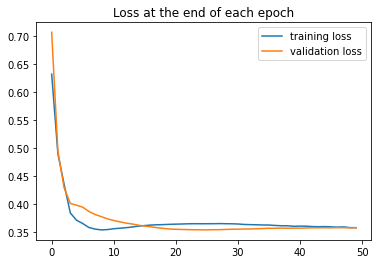

In [19]:
plt.plot(train_losses_3hd, label='training loss')
plt.plot(test_losses_3hd, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();